<a href="https://colab.research.google.com/github/SergeiVKalinin/MSE_Fall2023/blob/main/Module%206/17_Bayesian_Coin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The notebook for the University of Tennessee, Knoxville, Department of Materials Science and Engineering Fall 2023 course, "Introduction in Machine Learning for Materials Science".
- Instructor Sergei V. Kalinin

- These examples are based on the book "Bayesian Analysis with Python" by Oswaldo Martin, https://www.packtpub.com/product/bayesian-analysis-with-python-second-edition/9781789341652

- Warning: the book uses the deprecated PyMC3 library. Current version is PyMC - see https://www.pymc.io/welcome.html
- The adaptation of the code to PYMC is available at the author's GitHub https://github.com/aloctavodia/BAP/tree/master/code_5

In [1]:
import numpy as np
from scipy.stats import norm, binom, beta, bernoulli, t, multivariate_normal, poisson, randint, entropy, laplace, logistic
import matplotlib.pyplot as plt

Let's create Gaussian distribution with defined mean and dispersion, and draw three samples from it.

In [2]:
μ = 0.
σ = 1.
X = norm(μ, σ)
x = X.rvs(3)

print(x)

[0.47309626 0.33736427 0.25786873]


Now, let's visualize how Gaussian distributions look like for different mean and dispersions.  

[]

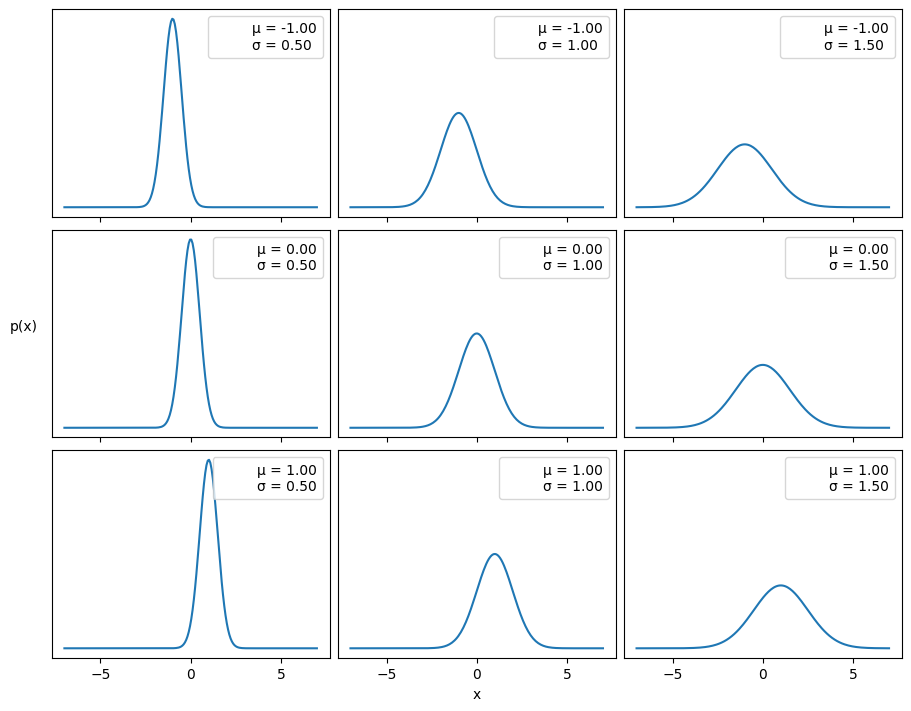

In [3]:
mu_params = [-1, 0, 1]
sd_params = [0.5, 1, 1.5]
x = np.linspace(-7, 7, 200)

_, ax = plt.subplots(len(mu_params), len(sd_params), sharex=True,
                     sharey=True,
                     figsize=(9, 7), constrained_layout=True)
for i in range(3):
    for j in range(3):
        mu = mu_params[i]
        sd = sd_params[j]
        y = norm(mu, sd).pdf(x)
        ax[i,j].plot(x, y)
        ax[i,j].plot([], label="μ = {:3.2f}\nσ = {:3.2f}".format(mu,
                     sd), alpha=0)
        ax[i,j].legend(loc=1)

ax[2,1].set_xlabel('x')
ax[1,0].set_ylabel('p(x)', rotation=0, labelpad=20)
ax[1,0].set_yticks([])

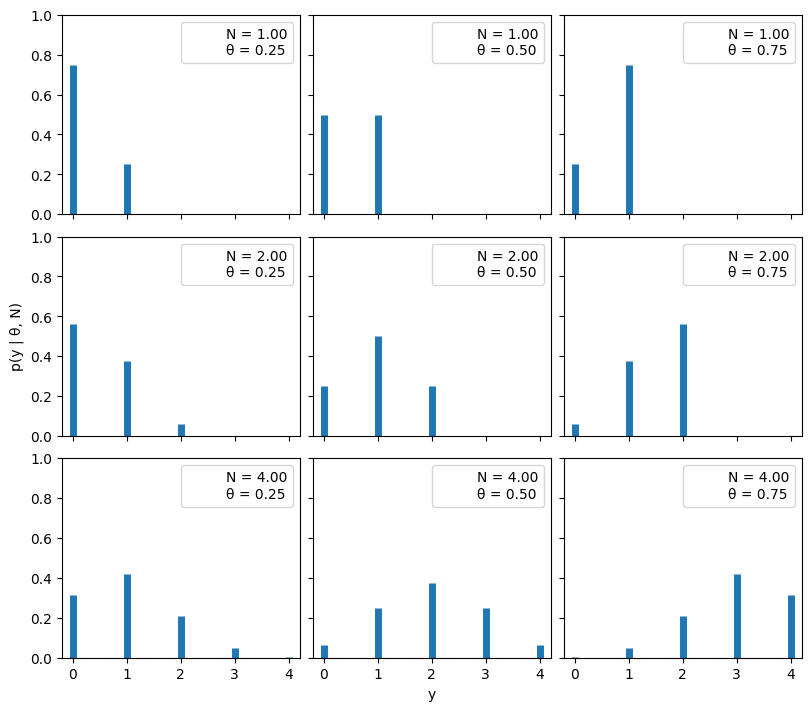

In [4]:
n_params = [1, 2, 4]  # Number of trials
p_params = [0.25, 0.5, 0.75]  # Probability of success

x = np.arange(0, max(n_params)+1)
f,ax = plt.subplots(len(n_params), len(p_params), sharex=True,
                    sharey=True,
                    figsize=(8, 7), constrained_layout=True)

for i in range(len(n_params)):
    for j in range(len(p_params)):
        n = n_params[i]
        p = p_params[j]

        y = binom(n=n, p=p).pmf(x)

        ax[i,j].vlines(x, 0, y, colors='C0', lw=5)
        ax[i,j].set_ylim(0, 1)
        ax[i,j].plot(0, 0, label="N = {:3.2f}\nθ = {:3.2f}".format(n,p), alpha=0)
        ax[i,j].legend()

        ax[2,1].set_xlabel('y')
        ax[1,0].set_ylabel('p(y | θ, N)')
        ax[0,0].set_xticks(x)

Text(0.07, 0.5, 'p(θ)')

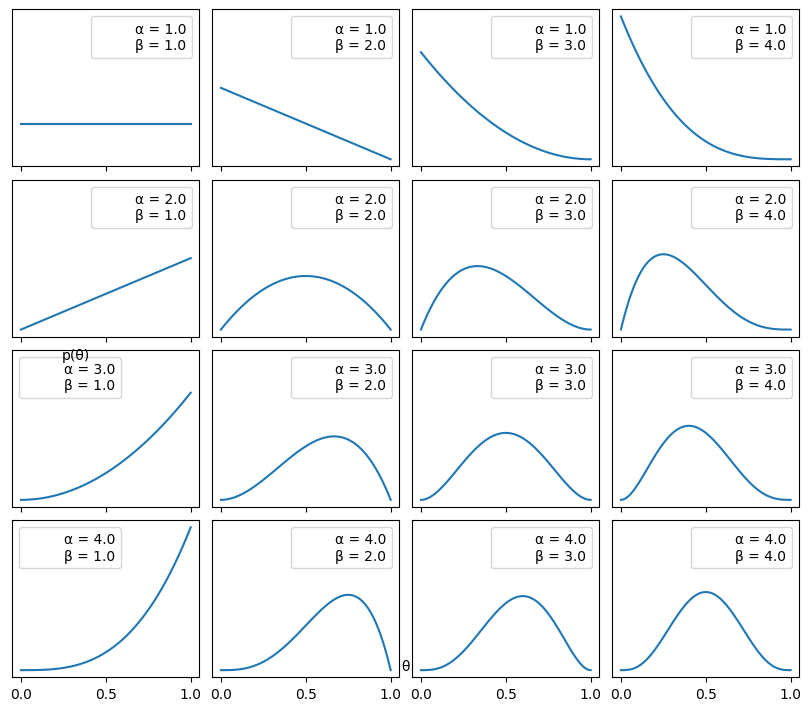

In [5]:
params = [1, 2, 3, 4]
x = np.linspace(0, 1, 100)
f, ax = plt.subplots(len(params), len(params), sharex=True,
                     sharey=True,
                     figsize=(8, 7), constrained_layout=True)

for i in range(4):
    for j in range(4):
        a = params[i]
        b = params[j]
        y = beta(a, b).pdf(x)
        ax[i,j].plot(x, y)
        ax[i,j].plot(0, 0, label="α = {:2.1f}\nβ = {:2.1f}".format(a,
                     b), alpha=0)
        ax[i,j].legend()
ax[1,0].set_yticks([])
ax[1,0].set_xticks([0, 0.5, 1])
f.text(0.5, 0.05, 'θ', ha='center')
f.text(0.07, 0.5, 'p(θ)', va='center', rotation=0)

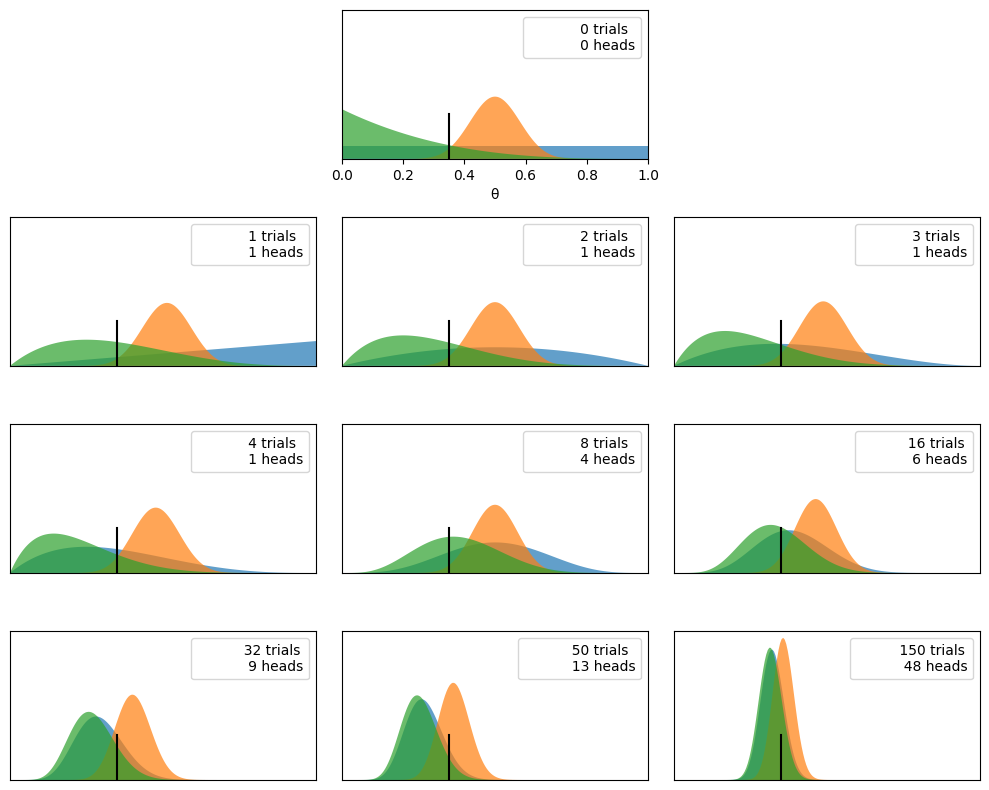

In [6]:
plt.figure(figsize=(10, 8))

n_trials = [0, 1, 2, 3, 4, 8, 16, 32, 50, 150]
data = [0, 1, 1, 1, 1, 4, 6, 9, 13, 48]
theta_real = 0.35

beta_params = [(1, 1), (20, 20), (1, 4)]
dist = beta
x = np.linspace(0, 1, 200)

for idx, N in enumerate(n_trials):
    if idx == 0:
        plt.subplot(4, 3, 2)
        plt.xlabel('θ')
    else:
        plt.subplot(4, 3, idx+3)
        plt.xticks([])
    y = data[idx]
    for (a_prior, b_prior) in beta_params:
        p_theta_given_y = dist.pdf(x, a_prior + y, b_prior + N - y)
        plt.fill_between(x, 0, p_theta_given_y, alpha=0.7)

    plt.axvline(theta_real, ymax=0.3, color='k')
    plt.plot(0, 0, label=f'{N:4d} trials\n{y:4d} heads', alpha=0)
    plt.xlim(0, 1)
    plt.ylim(0, 12)
    plt.legend()
    plt.yticks([])
plt.tight_layout()